In [61]:
from tqdm import tqdm

In [62]:
import torch.nn as nn

In [63]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torchvision import datasets
from torchvision import transforms
import torch
import torchvision
from sklearn.metrics import confusion_matrix

In [65]:
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"
print(device)
device = torch.device(device)

cuda:0


In [66]:
path = './sample_data'
cifar = datasets.CIFAR10(path, train = True, download = True, transform = transforms.ToTensor())

Files already downloaded and verified


In [67]:

cifar_stacked = torch.stack([img for img,_ in cifar], dim =3)
mean = cifar_stacked.view(3,-1).mean(dim = 1)
std = cifar_stacked.view(3,-1).std(dim =1)

#**Data Augmentation**

In [68]:
#transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
transform_test= transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_train = transforms.Compose([
    transforms.RandomRotation(degrees = 10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# **Batch Size**

In [69]:
batch_size = 4
cifar = datasets.CIFAR10(path, train = True ,download = False, transform = transform_train)
cifar_trainloader = torch.utils.data.DataLoader(cifar, batch_size = batch_size, shuffle = True)

In [70]:
cifar_test = datasets.CIFAR10(path, train = False, download = True, transform = transform_test)
cifar_testloader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False)

Files already downloaded and verified


# **CNN Model**


In [71]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = Conv2d(3, 32, kernel_size=3)
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = Conv2d(32, 64, kernel_size=5)
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = Conv2d(64, 64, kernel_size=3)
        self.relu3 = ReLU()
        self.fc1 = Linear(576, 64)
        self.relu4 = ReLU()
        self.fc2 = Linear(64, 10)
        self.logsoftmax = LogSoftmax(dim = 1)

    def forward(self, y):
        x = self.conv1(y)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1) # flatten the tensor for the fully connected layer
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x

# **Learning Rate**

In [72]:
init_lr = 1e-3

# **Optimiser and Scheduler**

In [73]:
model = CNN().to(device)
opt = torch.optim.SGD(model.parameters(), lr=init_lr)
use_scheduler = False
scheduler = None
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 100)

#**Loss Function**

In [74]:
use_kl = True
if use_kl:
    loss_fn = torch.nn.KLDivLoss(reduction = "batchmean")
else:
    loss_fn = torch.nn.CrossEntropyLoss()

# **Number of Epochs**

In [75]:
num_epochs = 30

epochs = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [76]:
num_epochs = 30

epochs = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for i in tqdm(range(num_epochs+1)):
  if i != 0:
    for j,imgs in enumerate(cifar_trainloader, 0):
      images, labels = imgs[0].to(device), imgs[1].to(device)
      out = model(images)
      if use_kl:
        loss = loss_fn(torch.nn.functional.log_softmax(out, dim =1).T, torch.nn.functional.softmax(labels.type(torch.cuda.FloatTensor), dim = 0))
      else:
        loss = loss_fn(out, labels)
      opt.zero_grad()
      loss.backward()
      if scheduler:
        scheduler.step()
      opt.step()

  with torch.no_grad():
    train_loss_i = 0.0
    val_loss_i = 0.0
    total_val = 0
    correct_val = 0
    correct_train = 0
    total_train = 0
    #Training Accuracy
    for k, imgs in enumerate(cifar_trainloader, 0):
      images, labels = imgs[0].to(device), imgs[1].to(device)
      out = model(images)
      if use_kl:
        loss = loss_fn(torch.nn.functional.log_softmax(out, dim =1).T, torch.nn.functional.softmax(labels.type(torch.cuda.FloatTensor), dim = 0))
      else:
        loss = loss_fn(out, labels)  
      train_loss_i += loss
      rando, predicted = torch.max(out, dim = 1)
      total_train += labels.shape[0]
      correct_train += int((predicted == labels).sum())
    train_acc.append(correct_train/total_train)
    train_loss.append(train_loss_i / total_train)

    #Validation Accuracy
    for l, imgs in enumerate(cifar_testloader, 0):
      images, labels = imgs[0].to(device), imgs[1].to(device)
      out = model(images)
      if use_kl:
        loss = loss_fn(torch.nn.functional.log_softmax(out, dim =1).T, torch.nn.functional.softmax(labels.type(torch.cuda.FloatTensor), dim = 0))
      else:
        loss = loss_fn(out, labels)  
      val_loss_i += loss
      rando, predicted = torch.max(out, dim = 1)
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())

    val_acc.append(correct_val/total_val)
    val_loss.append(val_loss_i / total_val)

  epochs.append(i)


100%|██████████| 31/31 [46:22<00:00, 89.75s/it]


In [77]:
# Compute class-wise accuracy and confusion matrix
# For class Wise Accuracy
num_classes = 10
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# initialize confusion matrix
conf_matrix = torch.zeros(num_classes, num_classes).to(device)

for imgs in cifar_test:
  image, label = imgs[0].to(device), imgs[1]
  out = model(image.unsqueeze(0))
  rando, predicted = torch.max(out, dim = 1)
  conf_matrix[label, predicted.item()] += 1
  class_total[label] += 1
  if label == predicted:
    class_correct[label] += 1

In [78]:
# print class-wise accuracy
for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
# # calculate total accuracy
# total_acc = sum(class_acc) / len(class_acc)
# print('Total accuracy:', total_acc.item())

Accuracy of     0 : 78 %
Accuracy of     1 : 89 %
Accuracy of     2 : 58 %
Accuracy of     3 : 53 %
Accuracy of     4 : 67 %
Accuracy of     5 : 71 %
Accuracy of     6 : 83 %
Accuracy of     7 : 82 %
Accuracy of     8 : 88 %
Accuracy of     9 : 80 %


In [79]:
class_correct

[789.0, 898.0, 585.0, 536.0, 679.0, 716.0, 838.0, 826.0, 886.0, 808.0]

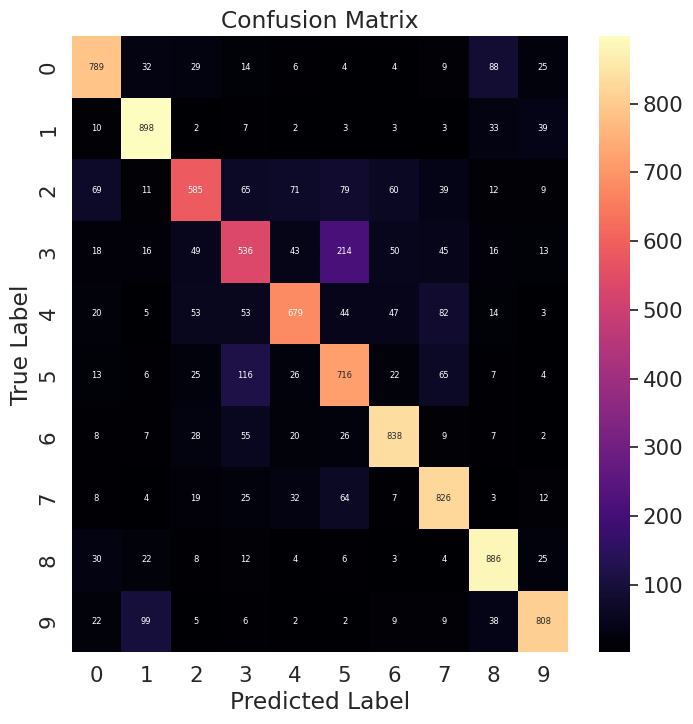

In [80]:
import seaborn as sns
conf_arr = conf_matrix.detach().cpu().numpy()
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_arr, annot=True, annot_kws={"size": 6}, cmap='magma', fmt='g', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes)) # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

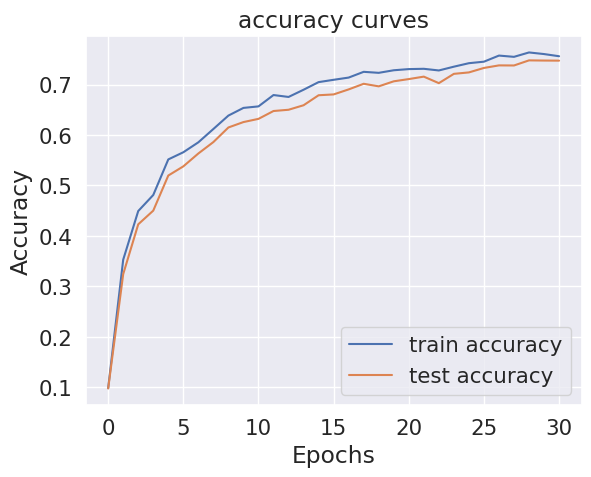

In [81]:
plt.plot(epochs, val_acc, label = "test accuracy")
plt.plot(epochs, train_acc, label = "train accuracy")
plt.title("accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [82]:
for i in range(len(val_loss)):
  val_loss[i] = val_loss[i].item()
  train_loss[i] = train_loss[i].detach().cpu().numpy()

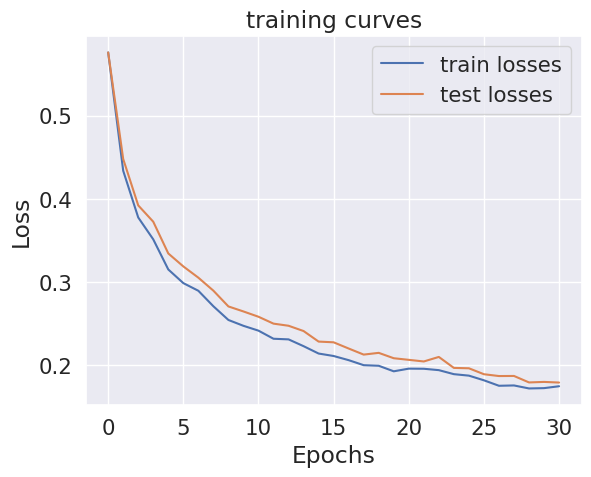

In [83]:
plt.plot(epochs, val_loss, label = "test losses")
plt.plot(epochs, train_loss, label = "train losses")
plt.title("training curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()